# Benoit's Problem with various RTO Algorithms

In [2529]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt

# 0. Benoit's Problem

In [2530]:

# Actual Plant System
def Benoit_System_1(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return f

def Benoit_System_2(u):
    f = u[0] ** 2 + u[1] ** 2 + (1 - u[0] * u[1])**2 + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2. + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def con1_system_tight(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def Benoit_System_noiseless_1(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1]   # + np.random.normal(0., np.sqrt(1e-3))
    return f

def Benoit_System_noiseless_2(u):
    f = u[0] ** 2 + u[1] ** 2 + (1 - u[0] * u[1])**2  # + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2.  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1

def con1_system_tight_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1]  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1

## Diagram for Benoit's Problem

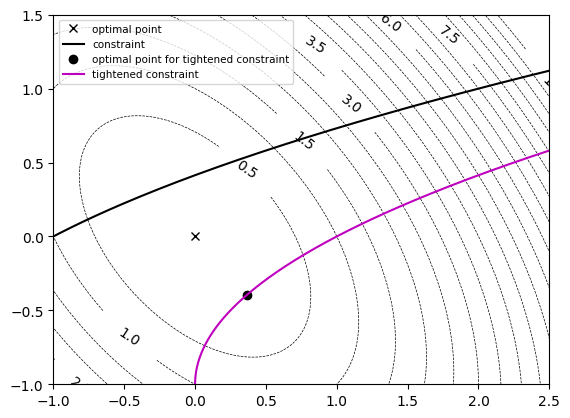

In [2531]:
# Plot for objective function 
def plant_drawing(is_constraint,is_tight_constraint):
        delta = 0.01
        x = np.arange(-3.5, 3.5, delta)
        y = np.arange(-3.5, 3.5, delta)
        u = np.meshgrid(x, y)
        levels = np.linspace(0,10,21)

        CS1 = plt.contour(u[0],u[1],Benoit_System_noiseless_1(u),levels,colors='k',linestyles = "dashed",linewidths = 0.5)
        plt.clabel(CS1,inline=True)
        plt.axis((-1, 2.5, -1, 1.5))

        if is_constraint == True:
                # Plot for optimal value for optimization with constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_noiseless(u)}) 
                result = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})
                
                ustar = result.x
                fstar = result.fun
                plt.plot(ustar[0],ustar[1],'kx')
                
                # Plot for constraint
                uc0 = 1. + x ** 2 + 2. * x - 2.
                constraint1 = plt.plot(uc0,x,'k')

        if is_tight_constraint == True:

                # Plot for optimal value for optimization with tightened constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_tight_noiseless(u)}) 
                result_tight = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})

                ustar = result_tight.x
                fstar = result_tight.fun
                plt.plot(ustar[0],ustar[1],'ko')

                # Plot for tightened constraint

                uc0t = 1. + x ** 2 + 2. * x
                constraint2 = plt.plot(uc0t,x,'m')

# plant_drawing(is_constraint=True,is_tight_constraint=False)
plant_drawing(is_constraint=True,is_tight_constraint=True)
plt.legend(["optimal point",
            "constraint",
            'optimal point for tightened constraint',
            'tightened constraint'],
                fontsize = 7.5)
plt.show()

# 1. Model Adaptation (Two step approach)

## A. Benoit Model (Modified Version) 

In [2532]:
# Plant Model 
def Benoit_Model(u,theta):
    f = theta[0] * u[0] ** 2 + theta[1] * u[1] ** 2
    return f

def con1_model(u,theta):
    g1 = 1. - theta[2]*u[0] + theta[3]*u[1] ** 2 
    return -g1

## B. Optimization on cost function

Optimization algorithm on cost function to find optimized input u given parameter

In [2533]:
# Optimization on cost function
def cost_optimize(theta,u0):
    con = ({'type': 'ineq', 
            'fun': lambda u: con1_model(u,theta)}) 
    result = minimize(Benoit_Model,
                    u0,
                    constraints= con,
                    method='SLSQP',
                    options={'ftol': 1e-9},
                    args= (theta))

    return result.x,result.fun

In [2534]:
# # Test
# u0 = [1,1] # Initial guess for optimization algorithm
# theta = [0.5,0.5,0.5,0.5]
# u,fun = cost_optimize(theta,u0)
# print(f"optimal input: {u}, optimal output: {fun}")


## C. Model Adaptation

We try to minimize difference between output of an actual plant and output of a model. 

The difference is measured by SSE (Sum of Squared Error), which is used for cost function to be minimized

In [2535]:
# cost function of adaptation
def SSE(theta,u,plant_func,plant_constraint):

    func_diff = plant_func(u) - Benoit_Model(u,theta)
    con_diff = plant_constraint(u) - con1_model(u,theta)

    return np.sqrt(func_diff**2+con_diff**2)

# Model Adaptation (Optimization of Parameters)
def SSE_optimize(plant_func,plant_constraint,theta0,u):

    result = minimize(SSE,
                      theta0,
                      method='SLSQP',
                      args= (u,plant_func,plant_constraint),
                      options= {'ftol': 1e-9})
    
    return result.x,result.fun


In [2536]:
# # test for adaptation cost function
# x = SSE(theta = [0.5,0.5,0.5,0.5],
#         u = [2,0],
#         plant_func = Benoit_System_noiseless_1,
#         plant_constraint =con1_system_noiseless)

# print(f"cost function:{x}")
# print("------------")

# # test for model adaptation method
# theta,fun = SSE_optimize(plant_func=Benoit_System_noiseless_1,
#                      plant_constraint=con1_system_noiseless,
#                      theta0=[0.5,0.5,0.5,0.5],
#                      u=[2.00000000e+00,-1.89234472e-08])

# print(f"optimal hyperparameters:{theta},\noptimal function: {fun}")

## D. Overall Algorithm

### I. Plant system: "Benoit_System_noiseless_1" plant system with "con1_system_noiseless" constraint

In [2537]:
# Initial Guess (k=0)
uk = [1,1]
thetak = [0.5,0.5,0.5,0.5]

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['parameters'] = [[thetak[0]],[thetak[1]],[thetak[2]],[thetak[3]]]
data['cost'] = [Benoit_Model(u=uk,theta=thetak)]

for i in range(5):


    # Model Optimization
    uk_1,fun = cost_optimize(theta=thetak,u0=uk)

    # Model Adaptation
    thetak_1,cost = SSE_optimize(plant_func=Benoit_System_noiseless_1,
                        plant_constraint=con1_system_noiseless,
                        theta0=thetak,
                        u=uk_1)

    uk = uk_1
    thetak = thetak_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(4):
        data['parameters'][i].append(thetak[i])
    data['cost'].append(fun) 

### II. Result Analysis

#### i. Trace of optimal input found by Model Adaptation Algorithm

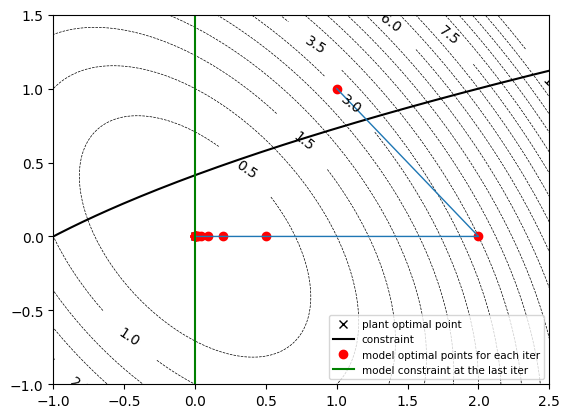

In [2538]:
plant_drawing(is_constraint=True,is_tight_constraint=False)
plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
uc1 = np.arange(-3.5, 3.5, delta)
uc0 = (data['parameters'][3][-1]*uc1**2 + 1)/data['parameters'][2][-1]
plt.plot(uc0,uc1,'g')
plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

#### ii. Cost Function through 5 iterations

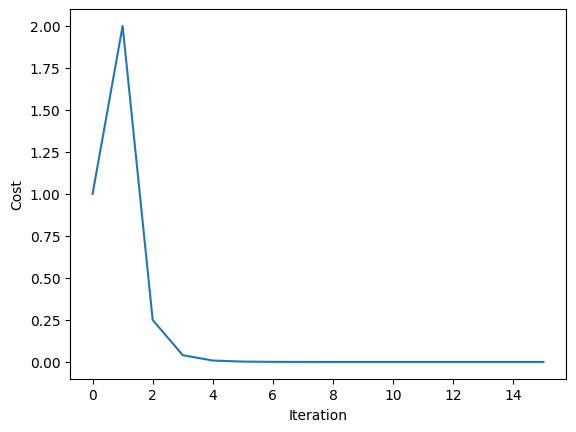

In [2539]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

#### iii. Parameters of model through 5 iterations

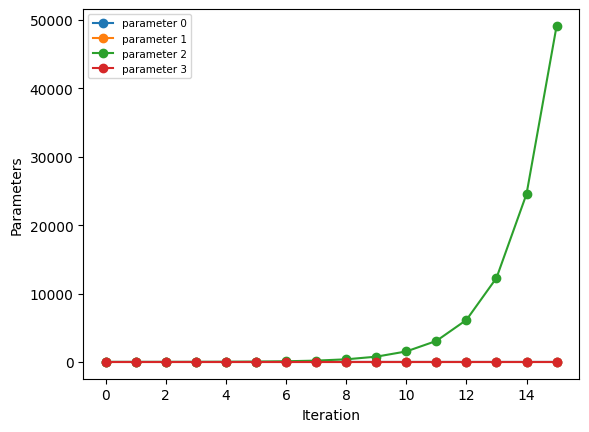

In [2540]:
plt.plot(data['index'],data['parameters'][0],data['index'],data['parameters'][1],data['index'],data['parameters'][2],data['index'],data['parameters'][3],
         marker='o')
plt.legend(["parameter 0",
            "parameter 1",
            "parameter 2",
            "parameter 3"],
            fontsize = 7.5)
plt.xlabel("Iteration"), plt.ylabel("Parameters")
plt.show()

### III. Plant system: "Benoit_System_noiseless_1" plant system with "con1_system_tight_noiseless" constraint

In [2541]:
# Initial Guess (k=0)
uk = [1,1]
thetak = [0.5,0.5,0.5,0.5]

# dictionary: uk_1, fun, thetak_1, cost, 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['parameters'] = [[thetak[0]],[thetak[1]],[thetak[2]],[thetak[3]]]
data['cost'] = [Benoit_Model(u=uk,theta=thetak)]

for i in range(5):

    # Model Optimization
    uk_1,fun = cost_optimize(theta=thetak,u0=uk)
    
    # Model Adaptation
    thetak_1,cost = SSE_optimize(plant_func=Benoit_System_noiseless_1,
                        plant_constraint=con1_system_tight_noiseless,
                        theta0=thetak,
                        u=uk_1)

    uk = uk_1
    thetak = thetak_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(4):
        data['parameters'][i].append(thetak[i])
    data['cost'].append(fun)


### IV. Result Analysis

#### i. Trace of optimal input found by Model Adaptation Algorithm

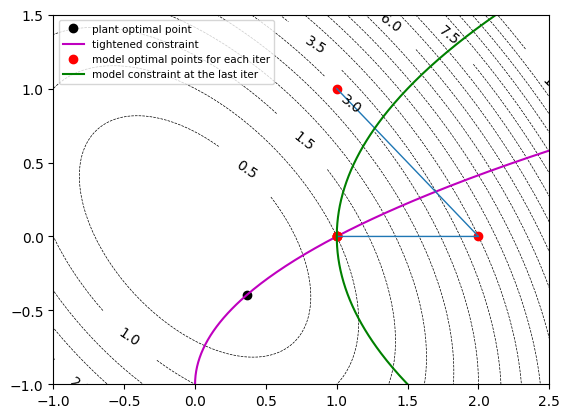

In [2542]:
plant_drawing(is_constraint=False,is_tight_constraint=True)
plt.plot(data['u_0'],data['u_1'], 'ro')
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
uc1 = np.arange(-3.5, 3.5, delta)
uc0 = (data['parameters'][3][-1]*uc1**2 + 1)/data['parameters'][2][-1]
plt.plot(uc0,uc1,'g')
plt.legend(["plant optimal point",
            "tightened constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

#### ii. Cost Function through 5 iterations

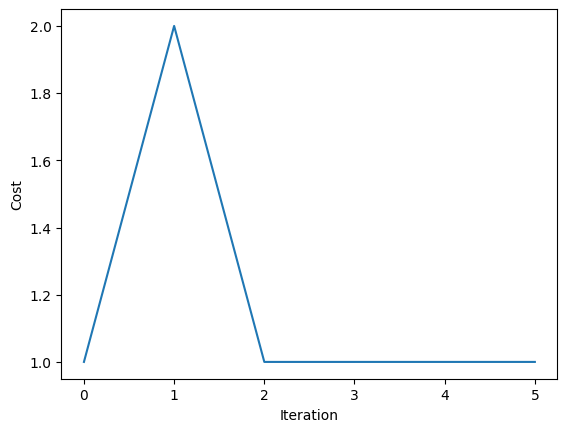

In [2543]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

#### iii. Parameters of model through 5 iterations

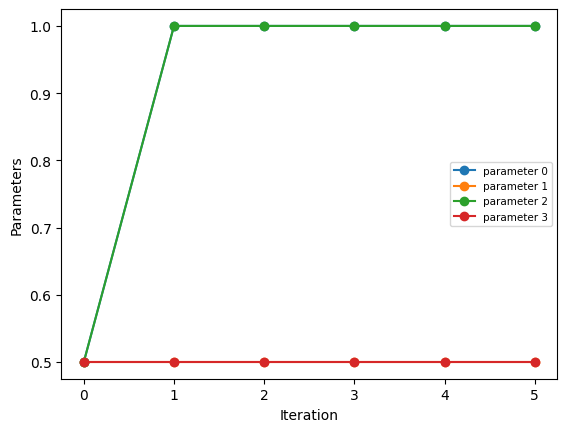

In [2544]:
plt.plot(data['index'],data['parameters'][0],data['index'],data['parameters'][1],data['index'],data['parameters'][2],data['index'],data['parameters'][3],
         marker='o')
plt.legend(["parameter 0",
            "parameter 1",
            "parameter 2",
            "parameter 3"],
            fontsize = 7.5)
plt.xlabel("Iteration"), plt.ylabel("Parameters")
plt.show()

# 2. Modifier Adaptation

## A. Benoit Model

In [2545]:
# Plant Model 
def Benoit_Model(u,theta,modifier):

    f = theta[0] * u[0] ** 2 + theta[1] * u[1] ** 2 + np.sum(modifier[2] * u)
    return f

def con1_model(u,u0,theta,modifier):

    g1 = 1. - theta[2]*u[0] + theta[3]*u[1] ** 2 + modifier[0] + np.sum(modifier[1]*(u-u0))
    return -g1


## B. Optimization on Cost Function

In [2546]:
def cost_optimize(u0,theta,modifier):

    con = ({'type': 'ineq',
            'fun': lambda u: con1_model(u,u0,theta,modifier)})
    
    result = minimize((Benoit_Model),
                    u0,
                    constraints= con,
                    method='SLSQP',
                    options= {'ftol': 1e-9},
                    args= (theta,modifier))
    
    return result.x,result.fun

In [2547]:
# Test
u0 = np.array([10,0]) # Initial guess for optimization algorithm
modifier = np.array([-0.6834536267626328,[-0.25      ,  0.74531547],[0.19976909, 0.19976909]],dtype=object) 
theta = np.array([0.5,0.5,0.5,0.5])

u,fun = cost_optimize(u0,theta,modifier)

print(f"optimal input: {u}, optimal output: {fun}")

optimal input: [ 3.39098837 -0.65105543], optimal output: 6.50869155160146


## C. Modifier Adaptation

In [2548]:
# gradient modifier
def gradient_estimation(u,fun):
    # step
    du = np.sqrt(1e-3) # np.finfo

    # Predicted gradient from real plant
    gradient_u0 = (fun(u+[du,0]) - fun(u))/du
    gradient_u1 = (fun(u+[0,du]) - fun(u))/du
    gradient = [gradient_u0,gradient_u1]
    
    return gradient

# Modifier Update
def modifier_update(u,u0,theta,modifier,plant_fun,plant_con1):
    
    # Calculate relavent bias and gradients:
    gradient_cost_p = gradient_estimation(u,plant_fun)
    ## Gradient of plant constraint function
    gradient_con1_p = gradient_estimation(u,plant_con1)
    ## Gradient of model cost function
    gradient_cost_m = approx_fprime(u,Benoit_Model,np.sqrt(1e-3),theta,modifier)
    ## Gradient of model constraint function
    gradient_con1_m = approx_fprime(u,con1_model,np.sqrt(1e-3),u0,theta,modifier)
    ## Gradient of plant cost function

    # Calculate difference between plant and model
    epsil = -(plant_con1(u) - con1_model(u,u0,theta,modifier))
    lamda_0 = -1*(gradient_con1_p - gradient_con1_m)
    lamda_1 = gradient_cost_p - gradient_cost_m 

    return [epsil,lamda_0,lamda_1]

# Modifier Adaptation
def adaptation(u,u0,theta,modifier,plant_fun,plant_con1,K):
    new_modifier = modifier_update(u,u0,theta,modifier,plant_fun,plant_con1)
    I = np.identity(np.shape(modifier)[0])

    for i in range(np.shape(modifier)[0]):
        modifier[i] = (I - K)[i,i]*modifier[i] + K[i,i]*new_modifier[i]

    return modifier

In [2549]:
# Test
## Variable
u = np.array([-0.20316229, -0.80316225])
u0 = np.array([-1,-1]) 
modifier = [1.4000000000000001,[0.5,0.80316228],[0.20316228,0.20316228]]
modifier = np.array([np.array(x) for x in modifier],dtype=object)
theta = np.array([0.5,0.5,0.5,0.5])
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_tight_noiseless

# Modifier Adaptation
modifier = adaptation(u,u0,theta,modifier,plant_fun,plant_con1,K)
print("New Modifier:")
print(modifier)


NameError: name 'K' is not defined

## D. Overall Algorithm

### I. Modifier Adaptation on "Benoit_System_noiseless_1" plant system with "con1_system_tight_noiseless" constraint

In [ ]:
uk = np.array([1,1]) 
modifier = [1,[1,1],[1,1]]
modifierk = np.array([np.array(x) for x in modifier],dtype=object)
theta = np.array([0.5,0.5,0.5,0.5])
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_tight_noiseless
K = np.identity(np.shape(modifierk)[0])*0.2

for i in range(20):
    uk_1,fun = cost_optimize(uk,theta,modifierk)
    modifierk_1 = adaptation(uk_1,uk,theta,modifierk,plant_fun,plant_con1,K)

    uk = uk_1
    modifierk = modifierk_1

print(f"optimal input: {uk_1}, optimal output: {fun} \n modifier: {modifierk_1}")

optimal input: [ 0.90818371 -0.52507148], optimal output: 0.6268228267804395 
 modifier: [-0.6835999658963197 array([-0.2499543 ,  0.74524562])
 array([0.19970882, 0.19970882])]


### Actual Optimized Input and Output


In [ ]:
u0 = [2,1] 
con = ({'type': 'ineq', 
        'fun': lambda u: con1_system_noiseless(u)}) 
result = minimize(Benoit_System_noiseless_1,
                u0,
                constraints= con,
                method='SLSQP',
                options={'ftol': 1e-9})

u = result.x
fun = result.fun

print(f"optimal input: {u}, optimal output: {fun}")

optimal input: [-4.97322951e-09 -4.97201070e-09], optimal output: 7.418085245734631e-17


### Result Analysis

The algorithm were not able to reach to the global optimization. However, it was able to approach to approximately good local minimum. Morevoer, the local mimimum changes according to theta. 

This allowed me to reevaluate on what modifier adaptation is doing.
- Approximated KKT matching -> prevents the algorithm to find global minimum
- Similar to upper confidence bound but without confidence intervals. Cannot perform exploration / only exploitation. 